<a href="https://colab.research.google.com/github/shellymduncan/Sales-Predictions/blob/main/Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales-Predictions (Project 1 - Part 2)

## Shelly-Ann Duncan

### 8/25/22

In [3]:
# mount drive

from google.colab import drive
drive.mount ('content_drive')

Mounted at content_drive


In [4]:
# import pandas as pd

import pandas as pd 

In [5]:
# load dataset

filename = ('/content/content_drive/MyDrive/02 - Week 2/sales_predictions (1).csv')
df = pd.read_csv('/content/content_drive/MyDrive/02 - Week 2/sales_predictions (1).csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
# 1. how many rows and columns?

df.shape

(8523, 12)

In [7]:
# 2. what are the datatypes for each variable?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
# 3. Are there duplicates? If so, drop any duplicates.

df.duplicated().any()

False

In [9]:
# 4. Identify missing values.

df.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

In [10]:
# 5. Adressing the missing values.
# does it make sense to drop? Let see.
# lets look at the total missing values in each column

df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
# the total number of values missing.

df.isna().sum().sum()

3873

In [12]:
# Filling in the missing data to see how it will afect my predictions.
#I don't want to run the risk of possibly losing valuable information.
### (I wanted to combine the fillna for both Item_Weight and Outlet_Size-(kept receivng error message)

In [13]:
df['Item_Weight'].mean().round(2)

12.86

In [14]:
df['Item_Weight'].fillna(value = 12.86, inplace = True)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [15]:
df['Outlet_Size'].mode()

0    Medium
dtype: object

In [16]:
df['Outlet_Size'].fillna(value = 'Medium', inplace = True)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
# 6. Checking for missing values after filling in the values that were missing.

df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [18]:
# 7. Find and fix inconsistent categories of data.

# examining the number of unique values in columns

df.nunique()


Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [19]:
# Cleaning up the Outlet_Size column

df['Outlet_Size'].value_counts()


Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [20]:
df['Outlet_Size'] = df['Outlet_Size'].replace('High', 'Large')
df['Outlet_Size'].value_counts()

Medium    5203
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

In [21]:
# Cleaning up the Outlet_Type column

df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [22]:
df['Outlet_Type'] = df['Outlet_Type'].replace('Grocery Store', 'Supermarket Type4')
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Supermarket Type4    1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [23]:
# Cleaning up the Item Fat Content Column.

df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [24]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    3006
LF          316
low fat     112
Name: Item_Fat_Content, dtype: int64

In [25]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF','Low Fat')
df['Item_Fat_Content'].value_counts()

Low Fat    5405
Regular    3006
low fat     112
Name: Item_Fat_Content, dtype: int64

In [26]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [27]:
 # 8. The summary statistics for any numberal column.

df.describe().round(2)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.23,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,9.31,0.03,93.83,1987.00,834.25
50%,12.86,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


## Project 1 - Part 3

### 9/1/22

### Complete any statistical analyses that might help you understand, explain, or model with your data. This must include at least one of each: Histogram, Boxplot, Heatmap.

# Histogram 

In [28]:
# changing the Outlet Establishment Year from int to object. This way when I plot the heatmap, the data appears clear an the year column doesn't show messy data.

df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype(object)
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year     object
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [29]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Supermarket Type4,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


In [30]:
# import libraries

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Plot a histogram comparing the Item Weight and the Item Outlet Sales.
# What can be seen by comparing the two?

df['Item_Weight'].head()

0     9.30
1     5.92
2    17.50
3    19.20
4     8.93
Name: Item_Weight, dtype: float64

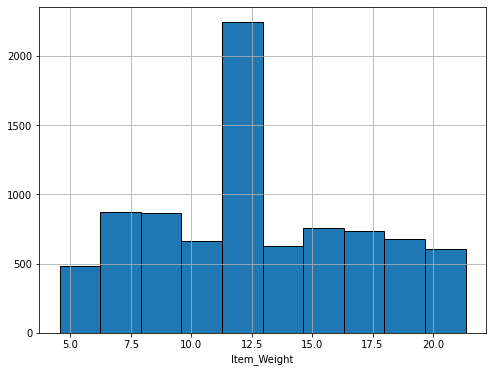

In [32]:
df.style.use('seaborn')
plt.figure(figsize = (8, 6))
plt.xlabel('Item_Weight')
df['Item_Weight'].hist(edgecolor = 'black')

In [33]:
df['Item_Outlet_Sales'].head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

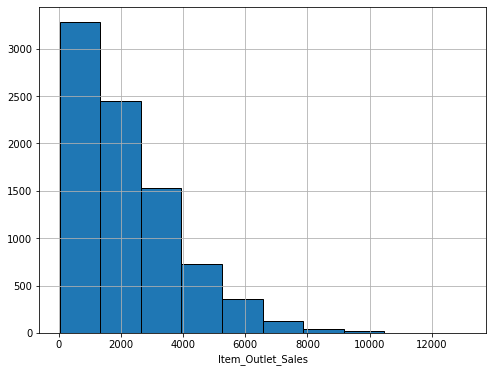

In [34]:
df.style.use('seaborn')
plt.figure(figsize = (8, 6))
plt.xlabel('Item_Outlet_Sales')
df['Item_Outlet_Sales'].hist(edgecolor = 'black');

1. Due to the major difference in scaling for 'Item Weight' and 'Item Outlet
Sales in the above histograms, the weight of an item doesn't have any affect on whether the item sells.
2. Graphing these two together will only cause the 'Item Weight' column to appear visible. Keeping them separate, you get a clear view of what each represent.


## Boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc2dc6f2610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc2dc6fb0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc2dc6f2090>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc2dc6fbb90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc2dc703110>,
 'means': []}

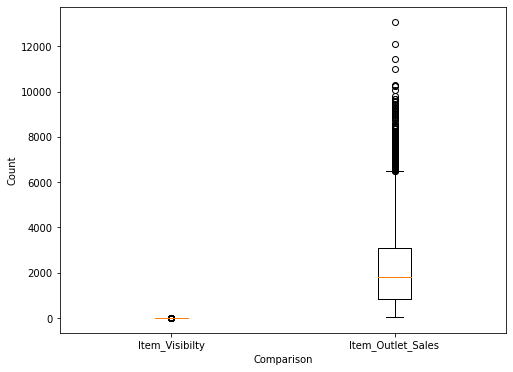

In [35]:
df.style.use('seaborn')
plt.figure(figsize = (8, 6))
plt.xlabel('Comparison')
plt.ylabel('Count')
plt.boxplot([df['Item_Visibility'], df['Item_Outlet_Sales']], labels = ['Item_Visibilty', 'Item_Outlet_Sales'])



1.   In the above box plot, the 'Item Visibility' has little to no relevance to the 'Item Outlet Sales'. 

2.  A lot of the data is in the outliers for 'Item Outlet Sales'. A lot of that data in the outlier can either be an error in the calculation of the sales or the sales may have been higher prices in certain Subermarket types.



 

# Heatmap

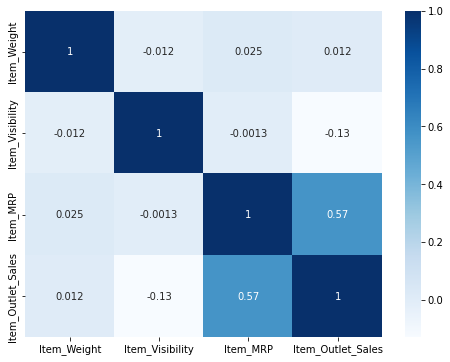

In [36]:
corr = df.corr()
df.style.use('seaborn')
plt.figure(figsize = (8, 6))
sns.heatmap(corr, cmap = 'Blues', annot = True)




1.  In the above heatmap, there is a strong correlation/relationship between 'Item MRP' and 'Item Outlet Sales'.




# Project 1 - Part 4

## Building visualizatons to help stakeholders better understand trends in the data.

In [37]:
# import additional libraries

import matplotlib.pyplot as plt
import numpy as np

In [38]:
# get the number of Item Outlet Sales per Outlet Establishement Year.
# changing the Outlet Establishment year back to an integer for the purpose comparing the above mentioned columns
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype(int)
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [39]:
numberYear = df.groupby(['Outlet_Establishment_Year'])['Item_Outlet_Sales'].nunique()
numberYear

Outlet_Establishment_Year
1985    1183
1987     788
1997     778
1998     391
1999     785
2002     776
2004     806
2007     777
2009     779
Name: Item_Outlet_Sales, dtype: int64

In [40]:
# converting to a numPy array

Years = np.array(numberYear.index)
Years

array([1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009])

In [41]:
Sales = np.array(numberYear.values)
Sales

array([1183,  788,  778,  391,  785,  776,  806,  777,  779])

Text(0.5, 1.0, 'Item Outlet Sales')

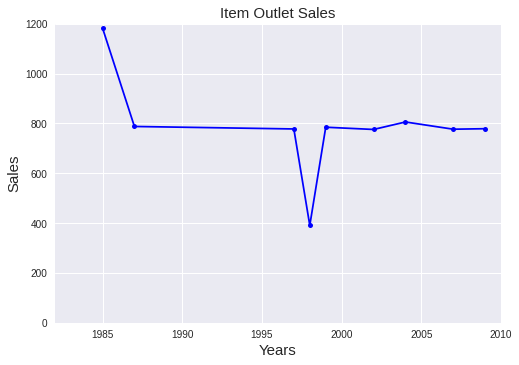

In [48]:
# Object-oriented style

plt.style.use('seaborn')
fig, axes = plt.subplots(nrows = 1, ncols = 1)
axes.plot(Years, Sales, c= 'b', marker = '.', markersize = 10)
axes.set_xlim(left=1982,right=2010)
axes.set_ylim(bottom=0,top=1200)
axes.set_xlabel('Years', fontsize = 15)
axes.set_ylabel('Sales', fontsize = 15)
axes.set_title('Item Outlet Sales', fontsize = 15)

1. There has been a significant decline in sales around between the years of 1995 and 2000. Mostly likely around year 1999.




Text(0.5, 1.0, 'MRP vs Sales')

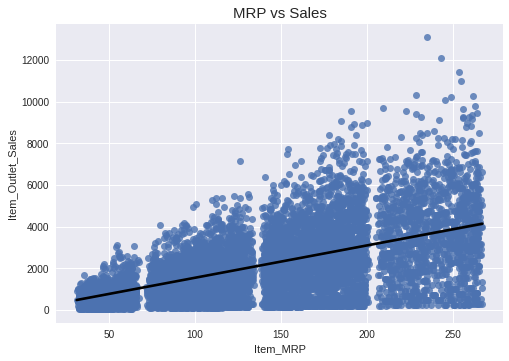

In [70]:
# creating a scatter plot 

plt.style.use('seaborn')
fig, axes = plt.subplots(nrows = 1, ncols = 1);
sns.regplot(data=df, x='Item_MRP', y='Item_Outlet_Sales', #scatter_kws={'s':2},
                line_kws={'color': 'black', 'ls': '-'})        
axes.set_title('MRP vs Sales', fontsize = 15)

1. The Item MRP has contributed to the increase in Item Outlet Sales.


